In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# 2. Kiểm tra phân phối nhãn
print(data['Class'].value_counts())

# 3. Chuẩn hóa các cột Amount và Time
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data['Time_scaled'] = scaler.fit_transform(data[['Time']])

# 4. Chọn tập huấn luyện chỉ chứa dữ liệu bình thường
train_data_normal = data[data['Class'] == 0].sample(n=10000, random_state=42)

# 5. Chọn tập kiểm tra gồm dữ liệu bình thường và bất thường
test_data_normal = data[data['Class'] == 0].sample(n=800, random_state=42)
test_data_fraud = data[data['Class'] == 1].sample(n=200, random_state=42)

# 6. Kết hợp tập kiểm tra
test_data = pd.concat([test_data_normal, test_data_fraud])
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Tạo X_train và X_test, bỏ cột Class, Amount và Time gốc
X_train = train_data_normal.drop(columns=['Class', 'Amount', 'Time'])
X_test = test_data.drop(columns=['Class', 'Amount', 'Time'])

# 8. Gán lại nhãn cho y_test
y_test = test_data['Class']

# 9. Thông tin kích thước tập dữ liệu
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(y_test.value_counts())

# 10. Chuyển dữ liệu thành tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# 11. Định nghĩa Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# 12. Định nghĩa Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 13. Khởi tạo mô hình và optimizer
latent_dim = 10
input_dim = X_train_tensor.shape[1]

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
criterion = nn.BCELoss()

# 14. Huấn luyện GAN
epochs = 50
batch_size = 32
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
    for real_data in train_loader:
        batch_size_cur = real_data.size(0)
        real_labels = torch.ones(batch_size_cur, 1)
        fake_labels = torch.zeros(batch_size_cur, 1)

        # Huấn luyện Discriminator
        optimizer_d.zero_grad()
        outputs_real = discriminator(real_data)
        d_loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size_cur, latent_dim)
        fake_data = generator(noise)
        outputs_fake = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Huấn luyện Generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size_cur, latent_dim)
        generated_data = generator(noise)
        outputs_fake_for_g = discriminator(generated_data)
        g_loss = criterion(outputs_fake_for_g, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# 15. Dự đoán trên tập kiểm tra
with torch.no_grad():
    anomaly_scores = discriminator(X_test_tensor).numpy().flatten()

# 16. Xử lý anomaly scores: ngưỡng thấp => bất thường
threshold = np.percentile(anomaly_scores, 5)  # 5% thấp nhất là bất thường
y_pred_test_adjusted = (anomaly_scores < threshold).astype(int)

# 17. Đánh giá mô hình
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_test_adjusted))
print("ROC AUC Score:", roc_auc_score(y_test, anomaly_scores))


Class
0    284315
1       492
Name: count, dtype: int64
Train size: 10000, Test size: 1000
Class
0    800
1    200
Name: count, dtype: int64
Epoch [1/50], d_loss: 0.3120, g_loss: 2.2891
Epoch [2/50], d_loss: 0.7171, g_loss: 1.9790
Epoch [3/50], d_loss: 0.2882, g_loss: 2.1152
Epoch [4/50], d_loss: 0.7590, g_loss: 2.0539
Epoch [5/50], d_loss: 1.1137, g_loss: 1.5465
Epoch [6/50], d_loss: 0.4649, g_loss: 2.3428
Epoch [7/50], d_loss: 0.4064, g_loss: 2.7952
Epoch [8/50], d_loss: 0.3913, g_loss: 3.0048
Epoch [9/50], d_loss: 0.3314, g_loss: 2.6680
Epoch [10/50], d_loss: 0.5419, g_loss: 2.2151
Epoch [11/50], d_loss: 0.7221, g_loss: 2.0355
Epoch [12/50], d_loss: 0.4366, g_loss: 1.7641
Epoch [13/50], d_loss: 0.6011, g_loss: 1.7889
Epoch [14/50], d_loss: 0.4253, g_loss: 2.2056
Epoch [15/50], d_loss: 0.4351, g_loss: 1.7003
Epoch [16/50], d_loss: 0.3651, g_loss: 1.7143
Epoch [17/50], d_loss: 0.3995, g_loss: 2.1542
Epoch [18/50], d_loss: 0.3714, g_loss: 1.9784
Epoch [19/50], d_loss: 0.2338, g_loss: 2

In [9]:
# 6. Dự đoán trên tập kiểm tra
discriminator.eval()
with torch.no_grad():
    test_probs = discriminator(X_test_tensor).numpy().flatten()

# 7. Đánh dấu dữ liệu dựa trên xác suất P
threshold = 0.5  # Nếu P >= 0.5 thì bình thường, ngược lại bất thường
y_pred = (test_probs >= threshold).astype(int)

# 8. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 9. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")


Confusion Matrix:
 [[ 11 589]
 [ 55 145]]

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.02      0.03       600
           1       0.20      0.72      0.31       200

    accuracy                           0.20       800
   macro avg       0.18      0.37      0.17       800
weighted avg       0.17      0.20      0.10       800

ROC AUC Score: 0.37166666666666665


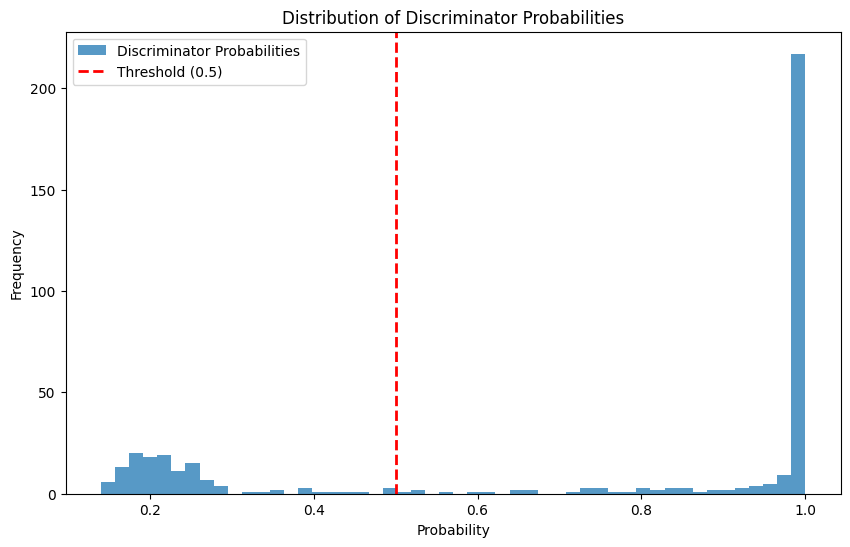

In [22]:

# 10. Vẽ biểu đồ phân phối xác suất dự đoán
plt.figure(figsize=(10, 6))
plt.hist(test_probs, bins=50, alpha=0.75, label='Discriminator Probabilities')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Probabilities')
plt.legend()
plt.show()